In [ ]:
import numpy as np
import geopandas as gpd
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tree_registration_and_matching.eval import obj_mee_matching

pd.options.mode.chained_assignment = None  # default='warn'

PLOT_BOUNDS = "/ofo-share/species-prediction-project/raw/ground-reference/ofo_ground-reference_plots.gpkg"
SHIFTS_FILE = "/ofo-share/species-prediction-project/intermediate/shifted_field_trees/shifts_per_dataset.json"
SHIFT_QUALITY_FILE = (
    "/ofo-share/scratch-david/species-tree-detection-eval/good_shifts.csv"
)
PREDS_FOLDER = "/ofo-share/scratch-david/species-tree-detection-eval/predictions"


def eval_dataset(preds_folder,dataset):
    tree_pred = f"{preds_folder}/{dataset}.gpkg"
    tree_gt = f"/ofo-share/species-prediction-project/intermediate/shifted_field_trees/{dataset}.gpkg"

    tree_preds = gpd.read_file(tree_pred)
    plot_bounds = gpd.read_file(PLOT_BOUNDS)
    try:
        tree_gt = gpd.read_file(tree_gt)
    except:
        print(f"Skipping {tree_gt} because it doesn't exist")
        return

    shifts = json.load(open(SHIFTS_FILE, "r"))
    # Get the particular shift for this dataset
    shift = shifts[dataset]
    # Get the bounds for this dataset
    plot = dataset[:4]
    plot_bound = plot_bounds.query("plot_id==@plot")

    tree_gt.to_crs(tree_preds.crs, inplace=True)
    plot_bound.to_crs(tree_preds.crs, inplace=True)
    # The trees used in evaluation are shifted. So we need to shift the plot bounds the corresponding amount
    plot_bound.geometry = plot_bound.translate(xoff=shift[0], yoff=shift[1])

    precision, recall, f1 = obj_mee_matching(
        shifted_field_trees=tree_gt,
        drone_trees=tree_preds,
        obs_bounds=plot_bound,
        min_height=10.0,
        edge_buffer=2.0,
        return_prec_recall=True,
    )

    return precision, recall, f1

def eval_all_preds(preds_folder):
    quality_shifts = pd.read_csv(SHIFT_QUALITY_FILE)
    quality_shifts = quality_shifts[quality_shifts["Unnamed: 1"] == "Good"]

    results = [eval_dataset(preds_folder, d[:-5]) for d in quality_shifts.dataset.tolist()]
    return results

def plot_results(results):
    results = list(filter(lambda x: x is not None, results))

    precision, recall, f1 = list(zip(*results))

    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)

    print(f"Mean precision: {mean_precision}, mean recall: {mean_recall}, mean f1: {mean_f1}")

    plt.hist(f1)
    plt.title("F1")
    plt.show()

    plt.hist(precision)
    plt.title("precision")
    plt.show()

    plt.hist(recall)
    plt.title("recall")
    plt.show()

    plt.scatter(precision, recall)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.show()

    return mean_precision, mean_recall, mean_f1



: 

In [ ]:
all_parameterization_folders = list(Path(PREDS_FOLDER).glob("*"))

all_parameterization_results = [eval_all_preds(f) for f in all_parameterization_folders]

#results = [plot_results(r) for r in all_parameterization_results]

Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0031_001420_001418.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0042_001419_001418.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0065_000333_000335.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0069_000781_000780.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0115_000643_000644.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0115_000645_000743.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0116_000646_000647.gpkg because it doesn't exist
Skipping /ofo-share/species-prediction-project/intermediate/shifted_field_trees/0031_001420_00141

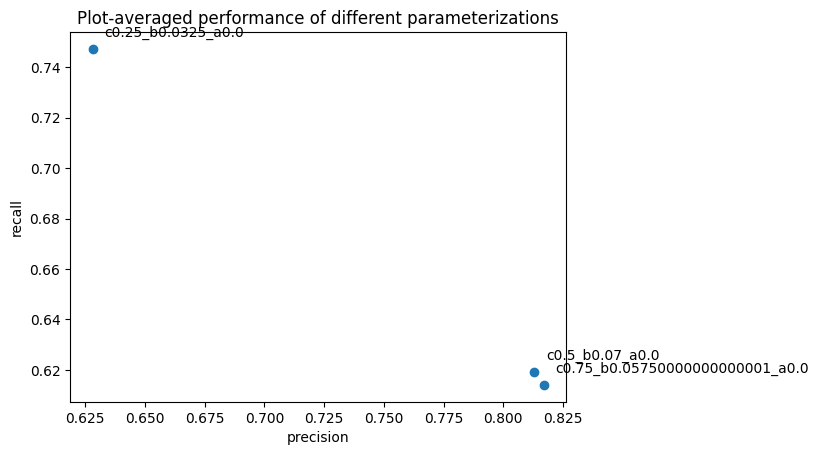

In [ ]:
precision, recall, f1 = zip(*results)

tags = [f.name[12:] for f in all_parameterization_folders]
plt.scatter(precision, recall)

for i, tag in enumerate(tags):
    plt.annotate(tag, (precision[i]+0.005, recall[i]+0.005))
plt.title("Plot-averaged performance of different parameterizations")
plt.xlabel("precision")
plt.ylabel("recall")
plt.show()

In [ ]:
print(len(recall))
with open("multi_dataset_eval_results.json", "w") as f:
    json.dump({"precision": precision, "recall": recall, "f1": f1, "tags": tags}, f)

25


In [ ]:
print(list(zip(tags, f1)))

[('c0.75_b0.05750000000000001_a0.0', np.float64(0.6201654194936084)), ('c0.5_b0.07_a0.0', np.float64(0.6197486703140647)), ('c0.25_b0.0325_a0.0', np.float64(0.6051718646360844)), ('c0.0_b0.07_a0.0', np.float64(0.6261885228024334)), ('c0.0_b0.02_a0.0', np.float64(0.03462398683970172)), ('c0.75_b0.02_a0.0', np.float64(0.6307545943687589)), ('c0.25_b0.05750000000000001_a0.0', np.float64(0.6347289705583496)), ('c0.5_b0.02_a0.0', np.float64(0.6034864888495721)), ('c0.5_b0.05750000000000001_a0.0', np.float64(0.6327628634003389)), ('c1.0_b0.045_a0.0', np.float64(0.6213253627098289)), ('c0.75_b0.0325_a0.0', np.float64(0.6406051320684822)), ('c0.0_b0.045_a0.0', np.float64(0.595139057800303)), ('c1.0_b0.0325_a0.0', np.float64(0.6324290506873336)), ('c0.5_b0.0325_a0.0', np.float64(0.630907263385942)), ('c0.25_b0.045_a0.0', np.float64(0.6291825131692826)), ('c1.0_b0.05750000000000001_a0.0', np.float64(0.6062101235842214)), ('c1.0_b0.07_a0.0', np.float64(0.58441355175011)), ('c0.0_b0.05750000000000

In [ ]:
best_parameterization_results = all_parameterization_results[-1]
best_tag = tags[-1]


quality_shifts = pd.read_csv(SHIFT_QUALITY_FILE)
quality_shifts = quality_shifts[quality_shifts["Unnamed: 1"] == "Good"]
datasets = quality_shifts.dataset.tolist()
print(best_tag)


c0.75_b0.07_a0.0


In [ ]:
recall = [r[1] if r is not None else 0 for r in best_parameterization_results]

sorting_args = np.argsort(recall)
print(len(datasets))
print(len(recall))

ordered_datasets = [datasets[i] for i in sorting_args]
ordered_recall = [recall[i] for i in sorting_args]

print(list(zip(ordered_datasets, ordered_recall)))

120
120
[('0031_001420_001418.gpkg', 0), ('0042_001419_001418.gpkg', 0), ('0069_000781_000780.gpkg', 0), ('0065_000333_000335.gpkg', 0), ('0116_000646_000647.gpkg', 0), ('0115_000645_000743.gpkg', 0), ('0115_000643_000644.gpkg', 0), ('0161_000211_000220.gpkg', 0.16), ('0081_001309_001307.gpkg', 0.16940789473684212), ('0273_001016_001015.gpkg', 0.1710843373493976), ('0187_001220_001221.gpkg', 0.1724137931034483), ('0143_000221_000229.gpkg', 0.2), ('0188_001206_001208.gpkg', 0.23255813953488372), ('0193_001207_001209.gpkg', 0.23809523809523808), ('0216_000321_000320.gpkg', 0.25), ('0137_000208_000210.gpkg', 0.25), ('0069_000227_000233.gpkg', 0.25206611570247933), ('0069_000782_000780.gpkg', 0.2628099173553719), ('0051_000174_000171.gpkg', 0.2796610169491525), ('0183_001238_001237.gpkg', 0.2962962962962963), ('0089_000192_000195.gpkg', 0.32038834951456313), ('0190_001218_001219.gpkg', 0.3333333333333333), ('0175_001270_001271.gpkg', 0.3333333333333333), ('0158_000211_000220.gpkg', 0.34285